# <center> L-TEM analysis of Magnetic Samples with MTIE</center>

This code will align the different images of magnetic samples captured using Lorentz microscopy (underfocus, infocus and overfocus) and calculates the magnetization of the sample using the transport of intensity equation (TIE)

author: Dr. Joseph Vas & Prof. Martial Duchamp

This code is developed based on the MTIE equation for quantifying magnetic domains measured using Lorentz TEM in a JEOL ARM 300 double corrected microscope in a field free conditions by switching off the objective lens. The image focus is done by the loretz lens available with the image corrector. The probe corrector is switched off except for the lens responsible for correcting the 2 and 3 stig.

The main reference for the algorithm is given below. 
<br>[1] V.V Volkov, Y Zhu, Lorentz phase microscopy of magnetic materials, Ultramicroscopy, Volume 98, Issues 2–4, 2004,pp. 271-281, ISSN 0304-3991,https://doi.org/10.1016/j.ultramic.2003.08.026.
<br>[2] https://learnopencv.com/image-alignment-ecc-in-opencv-c-python/

The formulation for the MTIE is given in [1].

The key equations for the calculation are





1. $\phi(r) = F^{-1}[F(k_{z}\delta_{z}I/I)/k_\bot^{2}]$
2. $t{B} = \frac{\hbar}{e}[n_{z}\times \Delta\phi]$

The algorithm used will be as follows,
<br>(1) Import the 3 images - under focus, in focus and over focus images
<br>(2) calculating the homography transform matrix of the underfocus and overfocus images with respect to the infocus image and aligning the out of focus images to the in-focus image
<br>(3) masking the areas with large fresnal frignes to eliminate spurious results
<br>(4) calculating the phase shift to the electron wave due to magnetic fields of the sample using equation 1.
<br>(5) calculating the magnetic field from the phase shift using equation 2.
<br>(6) Overlaying the field vectors on the in-phase images

## <center>This version of the code is optimized for working with Lorentz images with only 1 defocus </center>

<ins>Step 1</ins>. Importing the different dm4 images - underfocus, infocus and overfocus

<ins>importing relevant python libraries</ins>

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cv2
from scipy import ndimage
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label, regionprops
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom, binary_fill_holes
import plotly.graph_objects as go
import hyperspy.api as hs
import math
pi = np.pi
import glob
import os
from scipy import interpolate
from sklearn.cluster import KMeans

In [7]:
%matplotlib inline
#%pylab qt

<ins>importing the in-focus and out of the focus images collected in L-TEM</ins>

In [8]:
TEM2 = hs.load(r"in-focus.dm4") #in-focus
print("In focus =" , TEM2.data.shape)

In focus = (4096, 4096)


In [9]:
# for saving the data
pathf = r"out-focus.dm4"
dm4_file = glob.glob(pathf)
# the following will take out the location of the folder where we have to save the file 
loc_data_save = pathf[:-5]
print(len(dm4_file))
print(type(loc_data_save),'\n',loc_data_save)

1
<class 'str'> 
 out-focu


In [10]:
#file number 
i =0
path_dm4 = dm4_file[i]
file_name = os.path.basename(path_dm4)
print(file_name)
data_label = file_name + 'New 512'

out-focus.dm4


In [11]:
TEM1 = hs.load(path_dm4) #underfocus
print("undefocus =", TEM1.data.shape)

undefocus = (4096, 4096)


<ins>Step 2.</ins> Calculating the homography transform matrix of the underfocus and overfocus images with respect to the infocus image and aligning the out of focus images to the in-focus image.
<br> Before the phase information and the fields can be calculated from the L-TEM images, the artifacts brought in due to the defocus needs to be calculated. This is done by calculating the transforamtion- homography which takes into account the translation, rotation and sheer transformations due to the defocus. Another defocus effect is the introduction of fresnal fringes at the edges of the samples. This cannot be easily removed and thus is ignored.

<br>Before the transforms can be done, in-order to reduce the processing time, the images need to be binned down. This is written as a separate function

In [12]:
rebin_order = 8 #the order by which the size is to be binned
bin_sizex = TEM1.data.shape[0]/rebin_order
bin_sizey = TEM1.data.shape[1]/rebin_order

under_focus = TEM1.rebin([bin_sizex,bin_sizey])
TEM1N = under_focus
in_focus = TEM2.rebin([bin_sizex,bin_sizey])
TEM2N = in_focus
print(in_focus.rebin([4096,4096]).data.shape) # reverse binning
print(in_focus.data.shape)
print(in_focus.data.shape)

(4096, 4096)
(512, 512)
(512, 512)


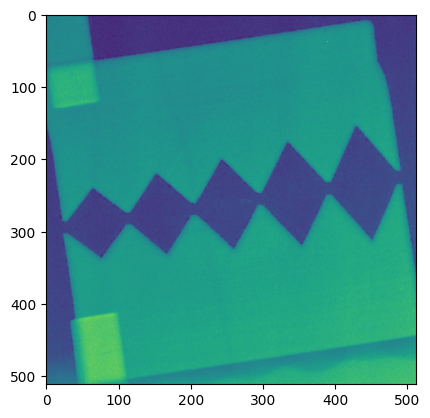

In [13]:
plt.imshow(in_focus.data)
plt.savefig("infocus.png",dpi=500)

<ins>aligning the images with respect to the in-focus image</ins>

<br> The transformation matrix is calculated in 2 stages, the first one to find the translation between the images. Once the translation is corrected, the rotation and sheer of the images are corrected for using the homography transform.

This function is used to calculate the translation, rotation and sheer transformation between the in-focus image and out of focus images

In [14]:
def align2d_cv(template_original,image_original,warp_mode): #function for calculating the alignments
    
    template = template_original.copy()
    image = image_original.copy()

    template_mean = np.mean(template)
    image_mean = np.mean(image)

    template[template>template_mean] = template_mean
    image[image>image_mean] = image_mean

    template[template<template_mean] = 0
    image[image<image_mean] = 0

    temp = cv2.normalize(template, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    imag = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    #find the shape
    sz = image.shape
    print(sz)

    #defining the mask
    mask = temp.copy()
    #mask_mean = np.mean(mask)
    #mask[mask>0.9*mask_mean] = 1
    #mask[mask<0.9*mask_mean] = 0

    mask[:,:] = 1
    mask[0,0] = 0
    
    
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
        
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)
          
     # Specify the number of iterations.
    number_of_iterations = 3000;
    
    # Specify the threshold of the increment
    termination_eps = 1e-10;
    
    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC(temp,imag,warp_matrix, warp_mode, criteria,mask,gaussFiltSize = 5)
    
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix[0,2] = warp_matrix[0,2] -4.5
        warp_matrix[1,2] = warp_matrix[1,2] +2
                # Use warpPerspective for Homography
        im2_aligned = cv2.warpPerspective (image_original, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else :
        # Use warpAffine for Translation, Euclidean and Affine
        im2_aligned = cv2.warpAffine(image_original, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
        print(warp_matrix)
    return(im2_aligned)      

In [15]:
under_focus_translated = align2d_cv(in_focus.data, under_focus.data, cv2.MOTION_TRANSLATION)
under_focus_affined = align2d_cv(in_focus.data, under_focus_translated, cv2.MOTION_HOMOGRAPHY)

(512, 512)
[[  1.          0.        -12.967659 ]
 [  0.          1.          1.1980326]]
(512, 512)


In [16]:
vmin_mul = 0.05
vmax_mul = 3

<ins>Plotting to check the alignments</ins>

Text(0.5, 1.0, 'difference')

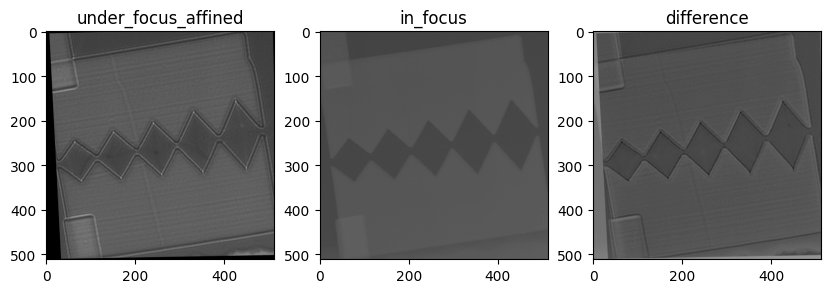

In [17]:
fig, ax = plt.subplots(figsize = (10,14),nrows = 1, ncols= 3)
image =under_focus_affined
ax[0].imshow((image), cmap='gray', \
                 vmin=vmin_mul*np.mean(image), vmax=vmax_mul*np.mean(image))
ax[0].set_title('under_focus_affined')

image =in_focus.data
ax[1].imshow((image), cmap='gray', \
                 vmin=vmin_mul*np.mean(image), vmax=vmax_mul*np.mean(image))
ax[1].set_title('in_focus')

image =in_focus.data-under_focus_affined
ax[2].imshow((image), cmap='gray', \
                vmin=vmin_mul*np.mean(image), vmax=vmax_mul*np.mean(image))
ax[2].set_title('difference')

<ins>Step 3.</ins> Creating the mask containing the region of interest
<br> Three things need to be done for a good mask. <br>(1) Remove the high frequency noise within the region of interest. This is done by fft filtering here. <br>(2) Remove the outer edges which are not of interest to the study. This is done by using a rectangle to cut off that region. <br>(3) remove a buffer layer from the edge to remove the areas influenced by fresnal fringes

4245390.5


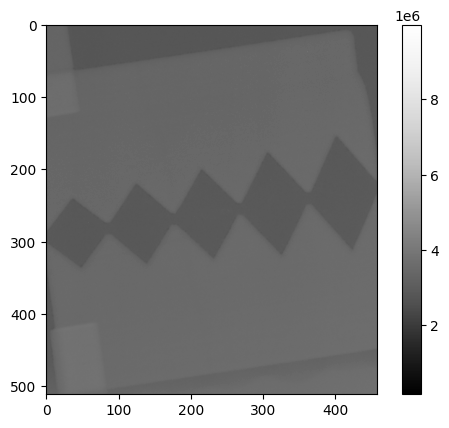

In [18]:
TEM2_data = TEM2N.data
plt.figure()
x_lim1 = 28
x_lim2 = -25
plt.imshow(TEM2_data[:,x_lim1:x_lim2], cmap='Greys_r',vmin=vmin_mul*np.mean(np.array(TEM2_data)), vmax=vmax_mul*np.mean(np.array(TEM2_data)))
plt.colorbar()
c = np.max(TEM2_data[:,x_lim1:x_lim2])
print(c)

Text(0.5, 1.0, 'Final image with mask')

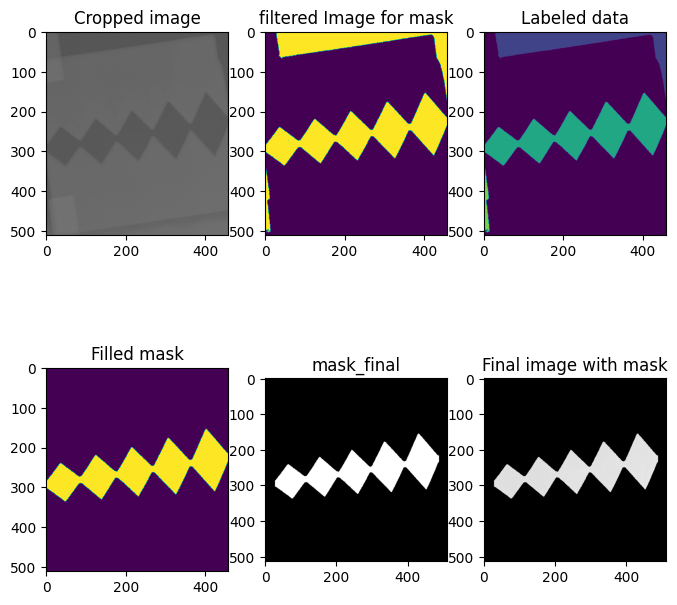

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
TEM2_data = TEM2N.data
ax[0, 0].imshow(TEM2_data[:,x_lim1:x_lim2], cmap='Greys_r',vmin=vmin_mul*np.mean(np.array(TEM2_data)), vmax=vmax_mul*np.mean(np.array(TEM2_data)))
ax[0, 0].set_title('Cropped image')# Add colorbar to the first subplot

mask = TEM2_data[:,x_lim1:x_lim2] < 3*c/4

ax[0, 1].imshow(mask)
ax[0, 1].set_title('filtered Image for mask')

mask_labeled = label(mask) # assigning each part of the image a label
ax[0,2].imshow(mask_labeled)
ax[0,2].set_title("Labeled data")

slc = mask_labeled
rps = regionprops(slc)
areas = [r.area for r in rps] # area of slices created in the array
idxs = np.argsort(areas)[::-1] # we want largest to smallest
new_slc = np.zeros_like(slc)
for i in idxs[:1]:
    new_slc[tuple(rps[i].coords.T)] = i+1
mask_f = new_slc>0
mask_ff= binary_fill_holes(mask_f) # there is no empty places inside the selected area of the image
ax[1,0].imshow(mask_ff)
ax[1,0].set_title('Filled mask')

mask_int = mask_ff.astype(int)
mask_final = np.zeros_like(np.array(TEM2N),dtype=int)

mask_final[:,x_lim1:x_lim2] = mask_int
ax[1,1].imshow(mask_final,cmap='gray')
ax[1,1].set_title('mask_final')

img = np.array(TEM2_data)*mask_final
ax[1,2].imshow(img,cmap='gray')
ax[1,2].set_title("Final image with mask")


<ins>Step 4.</ins> Calculating the phase of the wave due to magnetic sample. 
<br>Since we need to find the log of the intensity difference, having zero intensity in the data creates singularities. This has to be corrected before calculating the log.

<br>The calculating involves constants which can depend on the accelarating voltage which needs to be corrected for relativistic effects. One of the important constants is the defocus used for the measurements. This needs to be inputted.

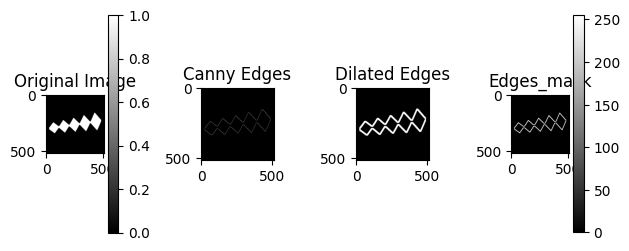

In [20]:
# Assuming mask_final is a NumPy array
if len(mask_final.shape) == 3 and mask_final.shape[2] == 3:
    # Check if the image is not already in grayscale
    gray_image = cv2.cvtColor(mask_final, cv2.COLOR_BGR2GRAY)
else:
    # Image is already in grayscale
    gray_image = mask_final.astype(np.uint8)  # Ensure the correct data type

# Apply GaussianBlur to reduce noise and help edge detection
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Use the Canny edge detector with adjusted parameters
edges = cv2.Canny(blurred_image, 1, 1)  # Adjust the thresholds if needed

# Display the original and processed images
plt.subplot(1, 4, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.colorbar()
plt.subplot(1, 4, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')

# Dilate the edges
kernel = np.ones((3, 3))
dilated_edges = cv2.dilate(edges, kernel, iterations= 4)

plt.subplot(1, 4, 3)
plt.imshow(dilated_edges, cmap='gray')
plt.title('Dilated Edges')
edges_mask = (dilated_edges*mask_final)

plt.subplot(1, 4, 4)
plt.imshow(edges_mask, cmap='gray')
plt.title('Edges_mask')
plt.colorbar()
plt.tight_layout()

plt.show()

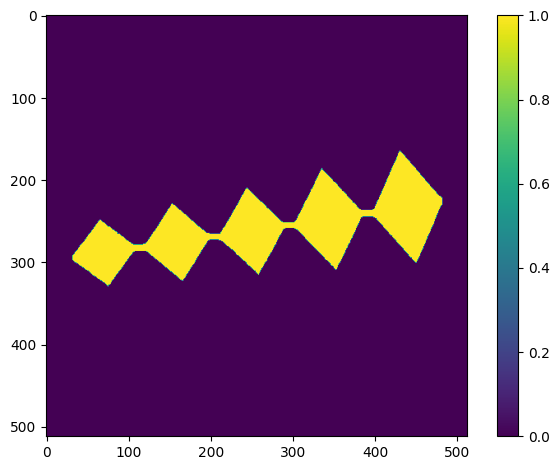

In [21]:
reu_mask = gray_image - edges_mask//250
plt.imshow(reu_mask)
plt.colorbar()
plt.tight_layout()

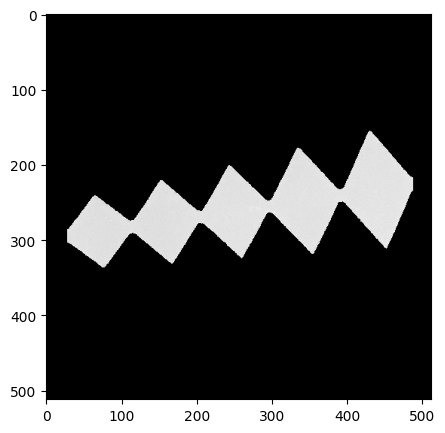

In [22]:
mask = in_focus.deepcopy()
mask_mean = np.mean(mask.data)
fig  = plt.figure(figsize =(10,5))
mask.data = mask.data*mask_final
plt.imshow(mask.data,cmap = 'gray')
plt.show()

In [23]:
#preventing singularity while taking log
under_focus_affined = under_focus_affined +0.001
in_focus_data = in_focus.data + 0.001

average_intensity = (under_focus_affined+in_focus_data)/2

#need to change with actual change of focus
df = 3000e-9*5e3 

#constants to be inputted
h = 6.626e-34
m = 9.1e-31
electron_charge = 1.6e-19
V = 388.06e3 # accelarating voltage corrected for relativistic effects
lamda = h/math.sqrt(2*m*electron_charge*V)
kz = 2*pi/lamda #this is for vacuum since the wave transformation between under focus and overfocus is in vacuum
t = 5e-9, #thickness of the sample

#calculating the part of equation 1 which will be FFTed
dz_logI = (under_focus_affined-in_focus_data)/(average_intensity*df)
#dz_logI = (log_over-log_under)/(df)
#dz_logI[mask.data<0.2] = 0 #applying mask
#dz_logI[dz_logI==0] = 1/kz

fft_dI = np.fft.fft2(kz*dz_logI)
fft_dI_shift = np.fft.fftshift(fft_dI)

#finding the k space vectors
pixel_dimensions = 18.747e-9*in_focus.original_metadata.ImageList.TagGroup0.ImageData.Calibrations.Dimension.TagGroup0.Scale*rebin_order
field_of_view = dz_logI.shape[0]*pixel_dimensions
#pixel_dimensions = 1

FreqCompRows = np.fft.fftfreq(dz_logI.shape[0],d=pixel_dimensions)
FreqCompCols = np.fft.fftfreq(dz_logI.shape[1],d=pixel_dimensions)


k_perp1 = np.zeros(dz_logI.shape)

for i in range(0,k_perp1.shape[0]):
    for j in range(0,k_perp1.shape[1]):
        k_perp1[i,j]= np.sqrt(FreqCompRows[i]*FreqCompRows[i]+FreqCompCols[j]*FreqCompCols[j])
        #if k_perp[i,j]< 1e6:
            #k_perp[i,j] = inf

#k_perp1[0,0] = 0.5e5 #removing the singularity caused when k_perp becomes 0
k_perp = np.fft.fftshift(k_perp1)+np.max(k_perp1)/0.5e2 # use a sufficiently small number to avoid the low frequency noise 
#k_perp[k_perp<5e5] = 5e5
fft_part = (fft_dI_shift/(k_perp**2))

#calculalating the phase of the wave when passing throught the sample
phi_crop = abs(np.fft.ifft2(np.fft.ifftshift(fft_part)))


In [24]:
pixel_dimensions = 18.747e-9*in_focus.original_metadata.ImageList.TagGroup0.ImageData.Calibrations.Dimension.TagGroup0.Scale*rebin_order
print(pixel_dimensions)

1.8939607664465904e-08


In [25]:
np.log10(k_perp1)

C:\Users\amren\AppData\Local\Temp\ipykernel_26172\3781148640.py:1: RuntimeWarning: divide by zero encountered in log10
  np.log10(k_perp1)


array([[      -inf, 5.01335906, 5.31438906, ..., 5.49048032, 5.31438906,
        5.01335906],
       [5.01335906, 5.16387406, 5.36284406, ..., 5.51335906, 5.36284406,
        5.16387406],
       [5.31438906, 5.36284406, 5.46490405, ..., 5.57033074, 5.46490405,
        5.36284406],
       ...,
       [5.49048032, 5.51335906, 5.57033074, ..., 5.64099531, 5.57033074,
        5.51335906],
       [5.31438906, 5.36284406, 5.46490405, ..., 5.57033074, 5.46490405,
        5.36284406],
       [5.01335906, 5.16387406, 5.36284406, ..., 5.51335906, 5.36284406,
        5.16387406]])

Plotting phase

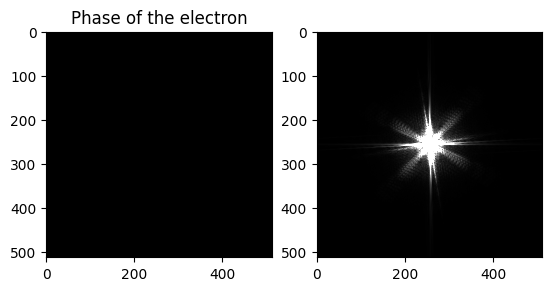

In [26]:
vmin_mul = 0.
vmax_mul = 2.5

fig, ax = plt.subplots(nrows = 1, ncols= 2)
image1 =abs(phi_crop)
#image2 = k_perp
image2 = abs(fft_part)
ax[0].set_title('Phase of the electron')
ax[0].imshow(np.log10(image1), cmap='gray', \
                 vmin=vmin_mul*np.mean(image1), vmax=vmax_mul*np.mean(image1))
ax[1].imshow(image2, cmap='gray', \
                 vmin=vmin_mul*np.mean(image2), vmax=vmax_mul*np.mean(image2))
plt.show()

<ins>Step 5.</ins> Calculating the magnetic information within the sample using equation 2
<br>The code gives the cumulative magnetic moment inside the sample

Calculates the X gradient and Y gradient of the image

In [27]:
def gradients(image,pixel_size):
    dim = image.shape
    grad_X = np.zeros((dim[0],dim[1]))
    grad_Y = np.zeros((dim[0],dim[1]))
    for i in range (0,dim[0]-1):
        for j in range (0,dim[1]-1):
            grad_X[i,j] =(image[i,j+1]-image[i,j])/pixel_size
            grad_Y[i,j] =-(image[i+1,j]-image[i,j])/pixel_size
    return(grad_X,grad_Y)

In [28]:
coeff = h/(2*pi*electron_charge)
(grad_X,grad_Y) = gradients(phi_crop,pixel_dimensions)

Bx = coeff*grad_Y/t
By = -coeff*grad_X/t

<ins>Step 6.</ins> Plotting the magnetic map within the specimen

In [29]:
angle = 84*np.pi/180
Bx_real = Bx*np.cos(angle)-By*np.cos(np.pi/2 -angle)
By_real = Bx*np.sin(angle)+By*np.sin(np.pi/2 -angle)
print(np.shape(Bx_real),np.shape(mask.data))
Bxreal_masked = np.ma.masked_where(mask.data < 1,Bx_real)
Byreal_masked = np.ma.masked_where(mask.data < 1,By_real)

(512, 512) (512, 512)


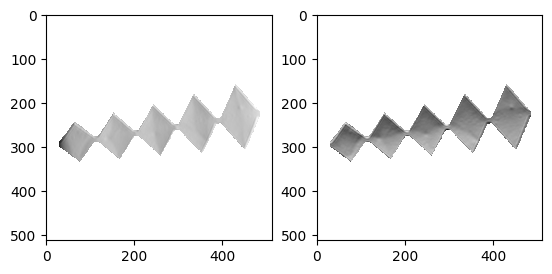

In [30]:
fig, ax = plt.subplots(nrows=1, ncols = 2)
ax[0].imshow(Bxreal_masked, cmap ='gray')
ax[1].imshow(Byreal_masked, cmap ='gray')
plt.show()

In [31]:
Bx_sum = sum(Bxreal_masked[mask == False].data)/Bxreal_masked[mask == False].data.shape
By_sum = sum(Byreal_masked[mask == False].data)/Byreal_masked[mask == False].data.shape
print('Bx = ', Bx_sum[0])
print('By = ', By_sum[0])

Bx =  -0.09507750695733468
By =  -0.001960558821778496


In [32]:
Bxreal_masked[mask == False].data.shape

(229598,)

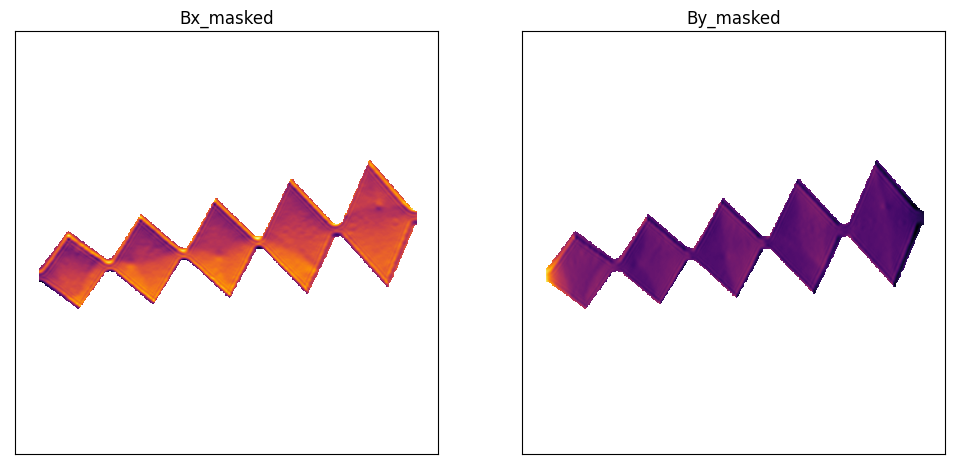

In [33]:
Bx_masked = np.ma.masked_where(mask.data < 1,Bx)
By_masked = np.ma.masked_where(mask.data < 1,By)

# Plot Bx_masked and By_masked
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].imshow(Bx_masked, cmap='inferno')
ax[0].set_title('Bx_masked')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(By_masked, cmap='inferno')
ax[1].set_title('By_masked')
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()

x_elements = Bx_masked.shape[0]
y_elements = By_masked.shape[0]
X,Y = np.meshgrid(np.arange(0,x_elements),np.arange(0,y_elements))


512 512


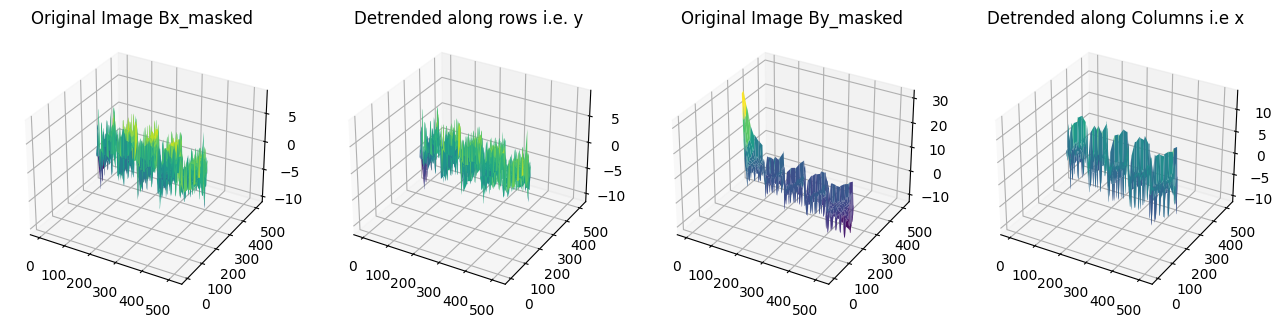

In [34]:
rows, cols = Byreal_masked.shape
print(rows,cols)

x = np.linspace(0, cols-1, cols)
y = np.linspace(0, rows-1, rows)
X, Y = np.meshgrid(x, y)

# Remove linear trend along each row
detrended_rows = Bx_masked - np.tile(np.mean(Bx_masked, axis=1, keepdims=True), (1, cols))

# Remove linear trend along eacBx_maskedh column
detrended_cols =  By_masked  - np.tile(np.mean(By_masked, axis=0, keepdims=True), (rows, 1))


# Plot the original and detrended images in 3D
fig = plt.figure(figsize=(16, 8))

# Original Image
ax = fig.add_subplot(141, projection='3d')
ax.plot_surface(X, Y, Bx_masked, cmap='viridis')
ax.set_title('Original Image Bx_masked ')

# Detrended along both rows and Columns
ax = fig.add_subplot(142, projection='3d')
ax.plot_surface(X, Y, detrended_rows, cmap='viridis')
ax.set_title('Detrended along rows i.e. y')

# Detrended along Columns
ax = fig.add_subplot(143, projection='3d')
ax.plot_surface(X, Y,By_masked , cmap='viridis')
ax.set_title('Original Image By_masked')

# Detrended along Rows
ax = fig.add_subplot(144, projection='3d')
ax.plot_surface(X, Y,detrended_cols , cmap='viridis')
ax.set_title('Detrended along Columns i.e x')

plt.show()

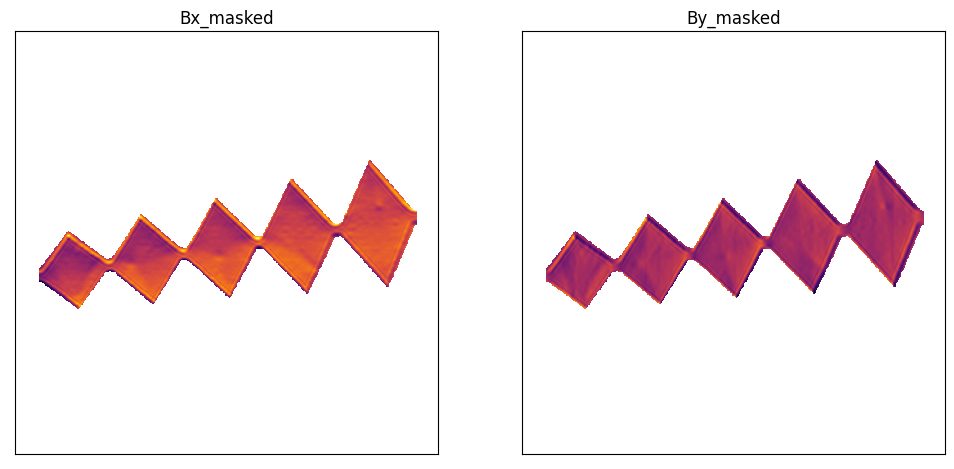

In [35]:
#reassign for comparison
Bx_masked = detrended_rows
By_masked = detrended_cols

# Plot Bx_masked and By_masked
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].imshow(Bx_masked, cmap='inferno')
ax[0].set_title('Bx_masked')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(By_masked, cmap='inferno')
ax[1].set_title('By_masked')
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()



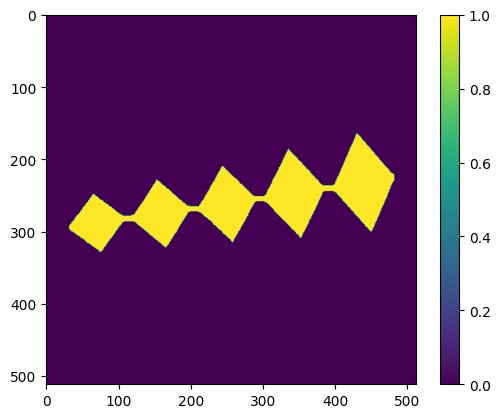

In [36]:
plt.imshow(reu_mask)
plt.colorbar()

In [37]:
Bx_masked = np.ma.masked_where(reu_mask < 1,detrended_rows)
By_masked = np.ma.masked_where(reu_mask < 1,detrended_cols)

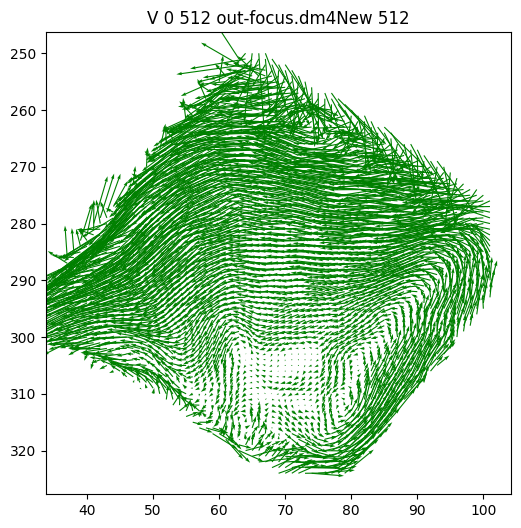

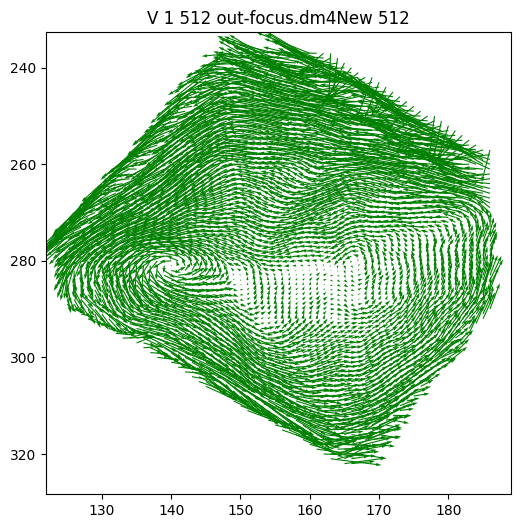

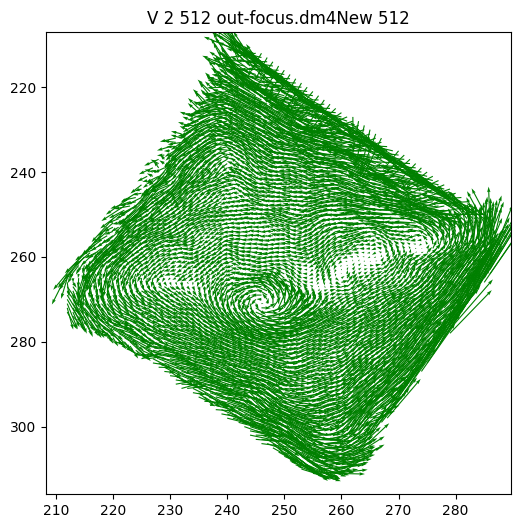

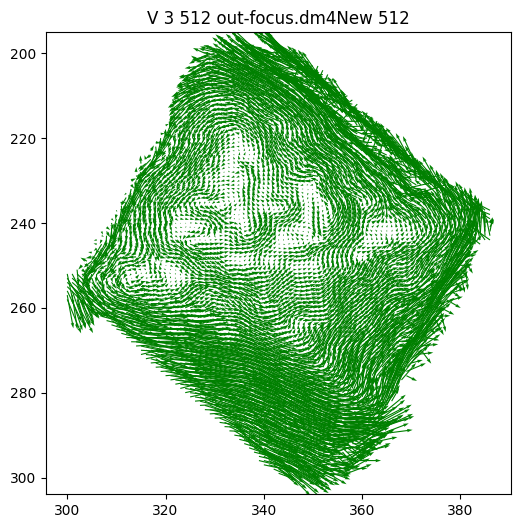

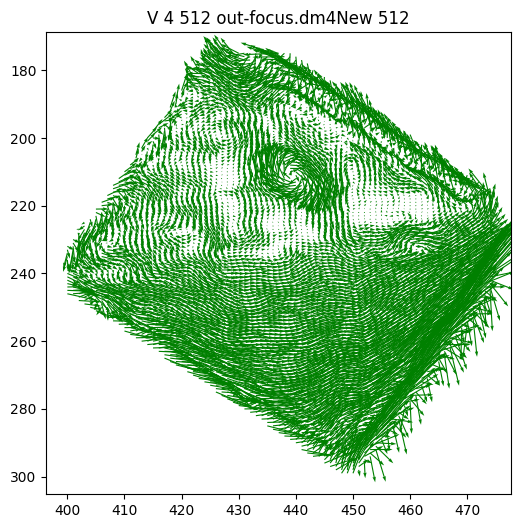

In [38]:
s = 40  # Divide the original scale by 2
Nx = Bxreal_masked.shape[0]
Ny = Bxreal_masked.shape[1]

x = np.linspace(0,Nx-1,Nx)
y = np.linspace(0,Ny-1,Ny)
X,Y = np.meshgrid(x,y)

# Subplot 1
plt.figure(figsize=(6, 6))
plt.quiver(X[250:325, 37:102], Y[250:325, 37:102], Bx_masked[250:325, 37:102], By_masked[250:325, 37:102], scale=s, color='g')
plt.gca().invert_yaxis()
plt.title("V 0 512 %s" % data_label)
plt.savefig(loc_data_save + 'V0_%s.png' % data_label, dpi=500, transparent=True)
plt.show()

# Subplot 2
plt.figure(figsize=(6, 6))
plt.quiver(X[237:325, 125:187], Y[237:325, 125:187], Bx_masked[237:325, 125:187], By_masked[237:325, 125:187], scale=s, color='g')
plt.gca().invert_yaxis()
plt.title("V 1 512 %s" % data_label)
plt.savefig(loc_data_save + 'V1_%s.png' % data_label, dpi=500, transparent=True)
plt.show()

# Subplot 3
plt.figure(figsize=(6, 6))
plt.quiver(X[212:312, 212:287], Y[212:312, 212:287], Bx_masked[212:312, 212:287], By_masked[212:312, 212:287], scale=s, color='g')
plt.gca().invert_yaxis()
plt.title("V 2 512 %s" % data_label)
plt.savefig(loc_data_save + 'V2_%s.png' % data_label, dpi=500, transparent=True)
plt.show()

# Subplot 4
plt.figure(figsize=(6, 6))
plt.quiver(X[200:300, 300:387], Y[200:300, 300:387], Bx_masked[200:300, 300:387], By_masked[200:300, 300:387], scale=s, color='g')
plt.gca().invert_yaxis()
plt.title("V 3 512 %s" % data_label)
plt.savefig(loc_data_save + 'V3_%s.png' % data_label, dpi=500, transparent=True)
plt.show()

# Subplot 5

plt.figure(figsize=(6, 6))
plt.quiver(X[175:300, 400:475], Y[175:300, 400:475], Bx_masked[175:300, 400:475], By_masked[175:300, 400:475],scale=s, color='g') #
plt.gca().invert_yaxis()
plt.title("V 4 512 %s" % data_label)
plt.savefig(loc_data_save + 'V4_%s.png' % data_label, dpi=500, transparent=True)
plt.show()

In [39]:
B_abs = np.sqrt(Bx**2 + By**2)

In [40]:
def RGB_phase(phase,mag,mag_max):
    color = np.zeros([phase.shape[0],phase.shape[1],4])
    phase = phase+180 # to change the range from [-180, 180] to [0, 360]
    for i in range(0, phase.shape[0]):
        for j in range(0,phase.shape[1]):
            #print(phase)
            if 0 <= phase[i,j] <= 120:
                r = (1/120)*phase[i,j]
                g = (-1/120)*phase[i,j]+1
                b = 0
            elif 120 <= phase[i,j] <= 240:
                r = (-1/120)*(phase[i,j]-120)+1
                g = 0
                b = (1/120)*(phase[i,j]- 120)
            elif 240 <= phase[i,j] <= 360:
                r = 0
                g = (1/120)*(phase[i,j]- 240)
                b = (-1/120)*(phase[i,j]-240)+1
            else:
                r = 0
                g = 0
                b = 0
            if r ==0 and g == 0 and b == 0:
                color[i,j,:] = [r,g,b,0]
            else:
                color[i,j,:] = [r,g,b,3*mag[i,j]/mag_max]
            #color[i,j,:] = [r,g,b,1]
            #color[i,j,:] = [r,g,b,mag[i,j]]
            #color[i,j,:] = [r,g,b,5*mag[i,j]/mag_max]
    return(color)

8.983724892165958


C:\Users\amren\AppData\Local\Temp\ipykernel_26172\3057206091.py:26: UserWarning: Warning: converting a masked element to nan.
  color[i,j,:] = [r,g,b,3*mag[i,j]/mag_max]
C:\Users\amren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cm.py:496: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


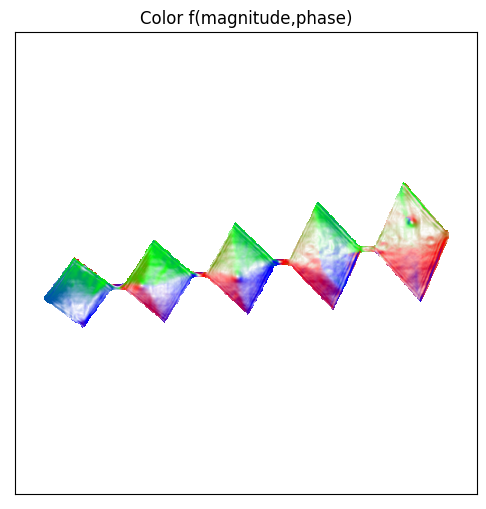

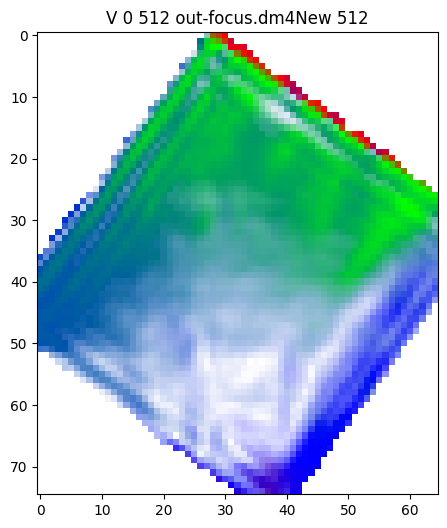

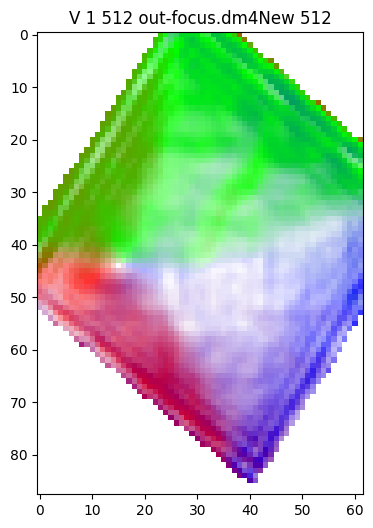

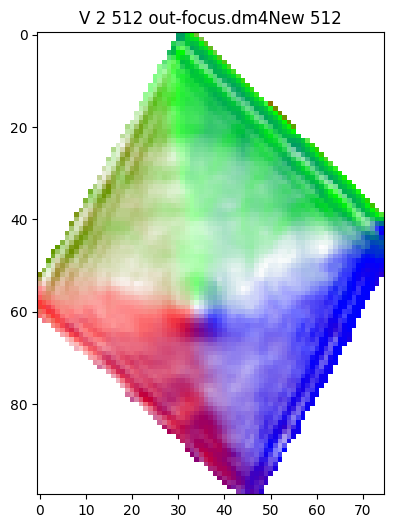

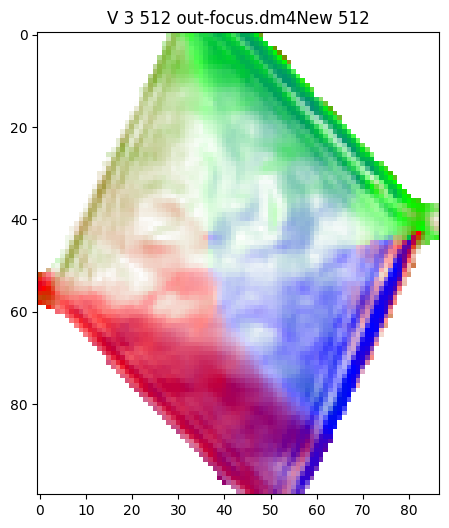

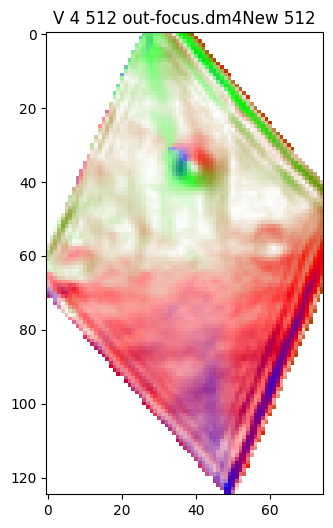

In [41]:
B = np.sqrt(abs(Bx_masked**2 + By_masked**2))

B_phase = np.arctan2(By, Bx) * 180 / np.pi

Bphase_masked = np.ma.masked_where(mask.data < 1,B_phase)
B_max =np.max(B[Bphase_masked.mask == False])
print(B_max)
#calling the color function
color =RGB_phase(Bphase_masked, B, B_max)

plt.figure(figsize=(6, 6))
plt.imshow(color, origin='lower')
plt.gca().invert_yaxis()
plt.title('Color f(magnitude,phase)')
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks

# Save and show the plot
#plt.savefig(loc_data_save + 'Color_f(%s).png' % data_label, dpi=500, transparent=True)
#plt.show()
# Subplot 1
plt.figure(figsize=(6, 6))
plt.imshow(color[250:325, 37:102], origin='lower')
plt.gca().invert_yaxis()
plt.title("V 0 512 %s" % data_label)
plt.savefig(loc_data_save + 'V0C_%s.png' % data_label, dpi=500, transparent=True)
plt.show()

# Subplot 2
plt.figure(figsize=(6, 6))
plt.imshow(color[237:325, 125:187], origin='lower')
plt.gca().invert_yaxis()
plt.title("V 1 512 %s" % data_label)
plt.savefig(loc_data_save + 'V1C_%s.png' % data_label, dpi=500, transparent=True)
plt.show()

# Subplot 3
plt.figure(figsize=(6, 6))
plt.imshow(color[212:312, 212:287], origin='lower')
plt.gca().invert_yaxis()
plt.title("V 2 512 %s" % data_label)
plt.savefig(loc_data_save + 'V2C_%s.png' % data_label, dpi=500, transparent=True)
plt.show()

# Subplot 4
plt.figure(figsize=(6, 6))
plt.imshow(color[200:300, 300:387], origin='lower')
plt.gca().invert_yaxis()
plt.title("V 3 512 %s" % data_label)
plt.savefig(loc_data_save + 'V3C_%s.png' % data_label, dpi=500, transparent=True)
plt.show()

# Subplot 5
plt.figure(figsize=(6, 6))
plt.imshow(color[175:300, 400:475], origin='lower')
plt.gca().invert_yaxis()
plt.title("V 4 512 %s" % data_label)
plt.savefig(loc_data_save + 'V4C_%s.png' % data_label, dpi=500, transparent=True)
plt.show()
